In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from qiskit.circuit.library.standard_gates import CHGate

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

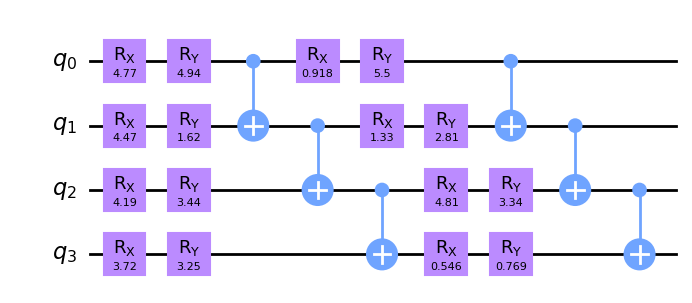

In [11]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712, 3.44120060, 3.24526326, 
                   0.91836107, 1.32971456, 4.80863498, 0.54593609, 5.49607802, 2.81204387, 3.34030218, 0.76854178]

size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

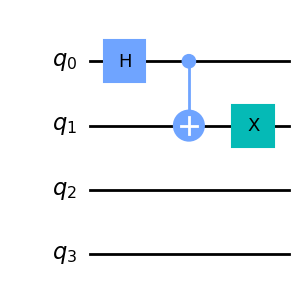

In [51]:
state = QuantumCircuit(4)
state.h(0)
#state.h(1)
state.cx(0, 1)
state.x(1)
state.draw('mpl')

In [52]:
'''
Extract the matrix representation of the state \rho_S
'''
psi = np.array(DensityMatrix.from_instruction(state.reverse_bits()))
rho = pt(psi, [3, 4], [2, 2, 2, 2])

In [53]:
'''
Define matrix representations of required gates.
'''
U0_1qubit = np.array([[np.exp(1j*np.pi/3), 0], [0, np.exp(-1j*np.pi/3)]], dtype=complex)
U0 = np.kron(U0_1qubit, U0_1qubit)
U2 = np.matmul(U0, U0)

In [54]:
'''
SDP to calculate the Fidelity. Refer to Section 5.
'''
shape = rho.shape

X = cp.Variable(shape, complex=True)
sig = cp.Variable(shape, complex=True)
G = cp.bmat([[rho, X.H],[X, sig]])

c = [sig>>0, G>>0, cp.real(cp.trace(sig))==1]

'''
Add the constraints to ensure that sig is G-symmetric
'''
c.append(U0@sig == sig@U0)
c.append(U2@sig == sig@U2)

obj = cp.Maximize(0.5*(cp.real(cp.trace(X)) + cp.real(cp.trace(X.H))))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 32 empty
WARN: A->p (column pointers) not strictly increasing, column 37 empty
WARN: A->p (column pointers) not strictly increasing, column 42 empty
WARN: A->p (column pointers) not strictly increasing, column 47 empty
Root Fidelity is : 0.999999999926638


In [55]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.999999999853276
